In [16]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy

YEAR = 2020


In [17]:
matchdata = pd.read_csv(f"../data/{YEAR}_MatchData.csv", index_col=[0,12])
matchdata = matchdata.loc[matchdata['Robot Number']==1,:]


 We want to determine how scores and win margins are distributed. If win
 margin distributions follow a consistent pattern, we can calculate the
 probability of a given win margin under a distribution. This would allow us to
 convert predicted win margins calculated by OPR into a rough estimation of win
 probability.

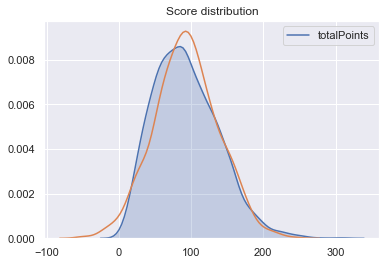

In [18]:
sns.kdeplot(matchdata.totalPoints, shade=True)
sns.kdeplot(np.random.normal(matchdata.totalPoints.mean(), matchdata.totalPoints.std(),1000))
plt.title("Score distribution")
plt.show()


 It looks like total score is approximately normally distributed. This holds
 for most games as well. We can quantify this similarity by calculating the
 likelihood of this data under a normal distribution.

In [19]:
def log_likelihood_normal(x, mu=None, sigma=None):
    if mu is None:
        mu = x.mean()
    if sigma is None:
        sigma = x.std()
    var = sigma**2

    return -np.log(2 * np.pi * var)/2 - ((x-mu)**2)/(2*(var))

ll = log_likelihood_normal(matchdata.totalPoints)
print("Log Likelihood:", ll.sum())


Log Likelihood: -21651.091327557962


 But a quantile-quantile plot is more useful for identifying normality.

((array([-3.58700141, -3.34869001, -3.2171899 , ...,  3.2171899 ,
          3.34869001,  3.58700141]),
  array([  0,   0,   0, ..., 282, 302, 314], dtype=int64)),
 (44.502095068344225, 93.39309845559846, 0.9890613546402229))

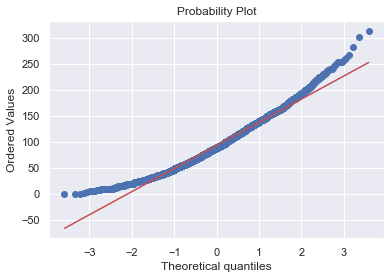

In [20]:
scipy.stats.probplot(matchdata.totalPoints, plot=plt)


 But we want to work with win *margins*, so let's split these scores into
 winners and losers and plot those along with win margins.

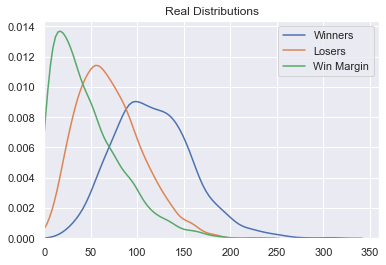

In [21]:
winners = matchdata.loc[matchdata.result=='W','totalPoints']
losers = matchdata.loc[matchdata.result=='L','totalPoints']

winners = np.array(winners)
losers = np.array(losers)

sns.kdeplot(winners, label="Winners")
sns.kdeplot(losers, label="Losers")
sns.kdeplot(winners - losers, label="Win Margin")
plt.title("Real Distributions")
plt.xlim(left=0)
plt.legend()
plt.show()


 The components look about normally distributed as well. Let's check that
 assumption.

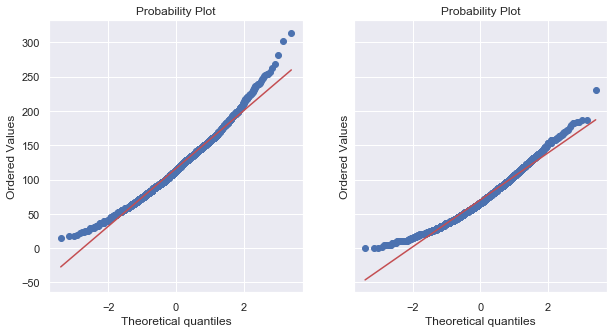

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
scipy.stats.probplot(winners, plot=ax1)
scipy.stats.probplot(losers, plot=ax2)
fig.show()


 It looks like they are indeed normal, with a bit of a longer tail toward the
 upper end. Let's see if we can model win margins as the difference between
 these normal distributions. We'll build a distribution for winners and losers
 and subtract them to get a distribution for expected win margins.

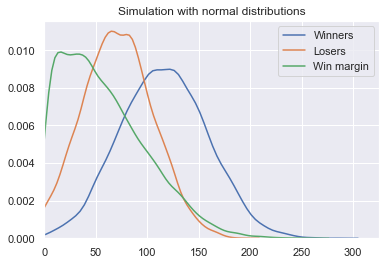

In [23]:
winners_norm = np.random.normal(winners.mean(), winners.std(), 10000)
losers_norm = np.random.normal(losers.mean(), losers.std(), 10000)
margins = np.abs(winners_norm - losers_norm)

sns.kdeplot(winners_norm, label="Winners")
sns.kdeplot(losers_norm, label="Losers")
sns.kdeplot(margins, label="Win margin")
plt.title("Simulation with normal distributions")
plt.xlim(left=0)
plt.legend()
plt.show()


 This model is pretty clearly a bad fit. Most obviously, it has a long tail
 that we don't see in the actual data. This suggests to me that there's more
 parity in match assignments than we might expect. This is probably because of
 qualified events like championships, but it's hard to say for sure.
 Regardless, we'll have to find a different distribution.